In [1]:
# https://docs.python.org/3/library/sys.html
import sys
# https://docs.python.org/3/library/hashlib.html#hash-algorithms
import hashlib
# https://pymultihash.readthedocs.io/en/latest/#
import multihash
# https://py-multicodec.readthedocs.io/en/stable/
from multicodec import add_prefix, remove_prefix, get_codec
# https://github.com/multiformats/py-multibase
import multibase
# https://github.com/parrt/lolviz
from lolviz import *
# https://github.com/parrt/lolviz#preferencess
prefs.max_str_len = 64
# https://github.com/parrt/lolviz/blob/master/examples.ipynb
from IPython.display import display
# https://bitstring.readthedocs.io/en/latest/index.html
from bitstring import Bits, BitArray, BitStream, ConstBitStream
# https://github.com/ilanschnell/bitarray
from bitarray import bitarray
from bitarray.util import int2ba, ba2int, strip
# https://github.com/multiformats/unsigned-varint
import varint
# https://github.com/tqdm/tqdm
from tqdm import tqdm
# https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html#object-creation
import numpy as np
import pandas as pd

In [2]:
# минимально необходимая длина для переданного целого
def bitLen(intValue):
    # работаем только с положительными целыми числами
    if intValue < 0:
        raise Exception("Only unsigned integers allowed")
    # для представления нуля все равно нужен 1 бит
    if intValue == 0:
        return 1
    length = 0
    while (intValue):
        intValue >>= 1
        length += 1
    return(length)

for i in range(17):
     print(i, ':', bitLen(i))

0 : 1
1 : 1
2 : 2
3 : 2
4 : 3
5 : 3
6 : 3
7 : 3
8 : 4
9 : 4
10 : 4
11 : 4
12 : 4
13 : 4
14 : 4
15 : 4
16 : 5


In [3]:
# привести двоичное значение к каноническому виду - убрать ведущие нули, сократить длину до минимально необходимой
def normalizeBinaryValue(value):
    intValue    = value.uint
    minLength   = bitLen(intValue) # len(int2ba(intValue, signed=False))
    newFormat = "uint:" + str(minLength) + "=" + str(intValue)
    return Bits(newFormat)

testNotNormalizedValue = Bits('0x111111')
print("Before normalization:", testNotNormalizedValue.bin, "|", len(testNotNormalizedValue))
testNormalizedValue = normalizeBinaryValue(testNotNormalizedValue)
print("After normalization:", testNormalizedValue.bin, "|", len(testNormalizedValue))

Before normalization: 000100010001000100010001 | 24
After normalization: 100010001000100010001 | 21


In [4]:
# compute hash block bytes or load it from menory
def getHashBlock(nounce, type="sha512"):
    nounceHash = hashlib.sha512(varint.encode(nounce)).digest()
    return Bits(bytes=nounceHash)

print(getHashBlock(1), len(getHashBlock(1)))
print(getHashBlock(2), len(getHashBlock(2)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339 512
0xfab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f69dcca 512


In [5]:
# вычислить два соседних блока хешей - чтобы можно было искать значения которые находятся на стыке блоков
def getExtendedHashBlock(nounce, type="sha512"):
    currentBlock = getHashBlock(nounce, type)
    nextBlock    = getHashBlock(nounce + 1, type)
    # prevBlock    = getHashBlock(nounce - 1, type)
    return (currentBlock + nextBlock)
print(getExtendedHashBlock(1), len(getExtendedHashBlock(1)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f... 1024


In [6]:
# получить часть пространства хешей двух соседних блоков в котором может находится указанное значение
def getSearchHashBlock(nounce, value):
    valueLength  = len(value)
    blockLength  = 512
    hashBlock = getExtendedHashBlock(nounce)
    # получаем длину пространства хешей двух смежных блоков в котором может располагаться значение
    searchLength = blockLength + valueLength - 1
    return hashBlock[0:searchLength]

# найти значение битовой последовательности внутри блока
def findValueInBlock(nounce, value, count=1, normalize=False, bytealigned=False, start=0):
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # добавляем несколько бит из соседнего блока чтобы можно было искать значения на стыке блоков
    hashBlock = getSearchHashBlock(nounce, value)
    return list(hashBlock.findall(value, start=start, count=count, bytealigned=bytealigned))

testSearchHashBlock = getSearchHashBlock(1, Bits('0x39fa'))
print(testSearchHashBlock, len(testSearchHashBlock))
testFindValueInBlock = findValueInBlock(1, Bits('0x39fa'))
print(testFindValueInBlock)
print(Bits('0x39fa').bin, len(Bits('0x39fa')))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab, 0b100 527
[504]
0011100111111010 16


In [7]:
# определить есть ли значение в указанном блоке
def hasValueInBlock(nounce, value):
    hashBlock = getExtendedHashBlock(nounce)
    values = findValueInBlock(nounce, value)
    return (len(values) > 0)

testHasValueInBlock1 = hasValueInBlock(1, Bits('0x39fa'))
print(testHasValueInBlock1)
testHasValueInBlock2 = hasValueInBlock(1, Bits('0x1111'))
print(testHasValueInBlock2)

True
False


In [8]:
# получить значение из блока хешей
def readValueFromBlock(nounce, start, length):
    end = start + length
    hashBlock = getExtendedHashBlock(nounce)
    return hashBlock[start:end]

testValueStartsBlock1EndsBlock2 = Bits('0x39fa') 
print(testValueStartsBlock1EndsBlock2)
print(readValueFromBlock(1, 504, 16))

0x39fa
0x39fa



Value search: 0x111111 000100010001000100010001 | 24
[FAIL: VALUE NOT FOUND]


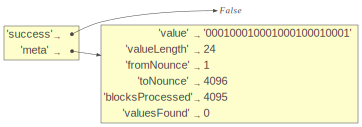


Value search: 0x111111 000100010001000100010001 | 24
[SUCCESS: VALUE FOUND]
0x111111


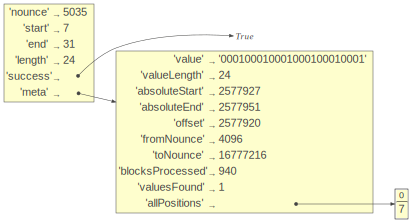

In [20]:
# найти значение в пространстве хешей, в рамках указанного диапазона блоков
# эта функция возвращает все позиции бит в блоке, с которых начинается переданное значение
def findValueInHashes(value, fromNounce, toNounce, normalize=False, bytealigned=False):
    # сохраняем переданное значение и его длину до нормализации
    inputValue       = Bits(value)
    inputValueLength = len(inputValue)
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # вычисляем длину найденного значения чтобы корректно вычислить координаты для чтения
    valueLength = len(value)
    # размер одного блока хеша в битах
    blockSize     = 512
    # количество просмотренных блоков
    blocksProcessed = 0
    for nounce in range(fromNounce, toNounce):
        # ищем значение в блоке
        startPositions  = findValueInBlock(nounce, value, normalize=normalize, bytealigned=bytealigned)
        blocksProcessed = blocksProcessed + 1
        # возвращаем координаты значения если оно присутствует в блоке
        if (len(startPositions) > 0):
            # абсолютное смещение внутри пространства хещей от первого блока (в битах)
            offset = blockSize * nounce
            # номер первого бита значения внутри блока
            start  = startPositions[0]
            # номер последнего бита значения внутри блока
            end    = start + valueLength
            # абсолютный адрес начала и конца последовательности в битах, начиная от 0
            absoluteStart = offset + start
            absoluteEnd   = offset + end
            return {
                "success": True,
                "nounce":  nounce,
                "start":   start,
                "end":     end,
                "length":  valueLength,
                "meta": {
                    "value":            value,
                    "valueLength":      valueLength,
                    # "inputValue":       inputValue,
                    # "inputValueLength": inputValueLength,
                    "absoluteStart":    absoluteStart,
                    "absoluteEnd":      absoluteEnd,
                    "offset":           offset,
                    "fromNounce":       fromNounce,
                    "toNounce":         toNounce,
                    "blocksProcessed":  blocksProcessed,
                    "allPositions":     startPositions,
                    "valuesFound":      len(startPositions),
                }
            }
    return {
        "success": False,
        "meta": {
            "value":            value,
            "valueLength":      valueLength,
            # "inputValue":       inputValue,
            # "inputValueLength": inputValueLength,
            "fromNounce":       fromNounce,
            "toNounce":         toNounce,
            "blocksProcessed":  blocksProcessed,
            "valuesFound":      0,
        }
    }

testFindValue = Bits('0x111111')
# test 1
testFindValueInHashes1 = findValueInHashes(testFindValue, 1, 2**12)
print("")
print("Value search:", testFindValue, testFindValue.bin, "|", len(testFindValue))
if (testFindValueInHashes1["success"]):
    print("[SUCCESS: VALUE FOUND]")
    valueFromHashes1 = readValueFromBlock(testFindValueInHashes1["nounce"], testFindValueInHashes1["start"], testFindValueInHashes1["length"])
    print(valueFromHashes1)
else:
    print("[FAIL: VALUE NOT FOUND]")
testFindValueInHashes1["meta"]["value"]      = testFindValueInHashes1["meta"]["value"].bin
# testFindValueInHashes1["meta"]["inputValue"] = testFindValueInHashes1["meta"]["inputValue"].bin
display(objviz(testFindValueInHashes1))

# test 2
testFindValueInHashes2 = findValueInHashes(testFindValue, 2**12, 2**24)
print("")
print("Value search:", testFindValue, testFindValue.bin, "|", len(testFindValue))
if (testFindValueInHashes2["success"]):
    print("[SUCCESS: VALUE FOUND]")
    valueFromHashes2 = readValueFromBlock(testFindValueInHashes2["nounce"], testFindValueInHashes2["start"], testFindValueInHashes2["length"])
    print(valueFromHashes2)
else:
    print("[FAIL: VALUE NOT FOUND]")
testFindValueInHashes2["meta"]["value"]      = testFindValueInHashes2["meta"]["value"].bin
# testFindValueInHashes2["meta"]["inputValue"] = testFindValueInHashes2["meta"]["inputValue"].bin
display(objviz(testFindValueInHashes2))

  0%|          | 0/65535 [00:00<?, ?it/s]


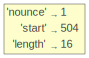

In [10]:
# создать указатель на найденное значение
def createPointerToValue(valueData):
    if (valueData["success"] == False):
        raise Exception("Pointer cannot be created: value not found")
    return {
        "nounce": valueData["nounce"],
        "start":  valueData["start"],
        "length": valueData["length"],
    }

testValueInHashes = findValueInHashes(Bits('0x39fa'), 1, 2**16)
testCreatePointerToValue = createPointerToValue(testValueInHashes)
display(objviz(testCreatePointerToValue))

In [11]:
# создать стандартный объект значения для заполнения словаря
def createDictValue(valueData):
    return {}

In [12]:
# все найденные в хешах значения
VALUE_DICT = pd.DataFrame()
# сохранить найденное в хешах значение в словарь
def saveValueToDict(valueData):
    return {}

In [14]:
bits8  = Bits('0b01001101')
bits16 = Bits('0b0100110101001101')
bits20 = Bits('0b01001101010011010100')
bits21 = Bits('0b010011010100110101001')
bits22 = Bits('0b0100110101001101010011')
bits23 = Bits('0b01001101010011010100110')
bits24 = Bits('0b010011010100110101001101')
bits25 = Bits('0b0100110101001101000000000')
bits26 = Bits('0b01001101010011010000000000')
bits27 = Bits('0b010011010100110100000000001')
bits28 = Bits('0b0100110101001101000000000010')
bits29 = Bits('0b01001101010011010000000000101')
bits30 = Bits('0b010011010100110100000000001010')
bits31 = Bits('0b0100110101001101000000000010101')
bits32 = Bits('0b01001101010011010000000000101010')
bits48 = Bits('0b010011010100110100000000001010100000000000000011')
bits49 = Bits('0b01010101010101010101010101010101010101010101010101')
# test
searchResults = []
testBits      = bits24 # bits48
fromNounce    = 0
# bits from 8 to 32
for bitSize in range(16, len(testBits)):
    searchBits   = Bits(testBits[0:bitSize])
    toNounce     = 2**bitSize
    print("")
    print("Bit:", bitSize, '/', len(testBits),  " -> ", searchBits.bin, len(searchBits))
    print("")
    searchResult = findValueInHashes(searchBits, fromNounce, toNounce)
    print("")
    print(searchResult)
    if (searchResult["success"]):
        fromNounce = searchResult["nounce"]
    else:
        raise ValueError("Value not found")
    searchResults.append(searchResult)
    
    
# testSearch[] = findValueInHashes(bits25, 0, 2**24)
# testSearch[] = findValueInHashes(bits26, testSearch[25]["nounce"], 2**25)
# display(objviz(searchResults))
for testResult in searchResults:
    print(testResult)

  0%|          | 576/524167 [00:00<01:31, 5753.17it/s]
Bit: 16 / 24  ->  0100110101001101 16


{'success': True, 'nounce': 6, 'start': 502, 'end': 518, 'length': 16, 'meta': {'value': Bits('0x4d4d'), 'valueLength': 16, 'absoluteStart': 3574, 'absoluteEnd': 3590, 'offset': 3072, 'fromNounce': 0, 'toNounce': 65536, 'blocksProcessed': 7, 'allPositions': [502], 'valuesFound': 1}}

Bit: 17 / 24  ->  01001101010011010 17


{'success': True, 'nounce': 121, 'start': 421, 'end': 438, 'length': 17, 'meta': {'value': Bits('0b01001101010011010'), 'valueLength': 17, 'absoluteStart': 62373, 'absoluteEnd': 62390, 'offset': 61952, 'fromNounce': 6, 'toNounce': 131072, 'blocksProcessed': 116, 'allPositions': [421], 'valuesFound': 1}}

Bit: 18 / 24  ->  010011010100110101 18


{'success': True, 'nounce': 121, 'start': 421, 'end': 439, 'length': 18, 'meta': {'value': Bits('0b010011010100110101'), 'valueLength': 18, 'absoluteStart': 62373, 'absoluteEnd': 62391, 'offset': 61952, 'fromNounce': 121, 'toNounce

In [15]:
bytes4 = bits32.tobytes()
print(bits32.tobytes())
print(bytes4[0], '=', bytes4[0:1].decode('UTF-8'))
print(bytes4[1], '=', bytes4[0:1].decode('UTF-8'))
print(bytes4[2], '=', bytes4[0:1].decode('UTF-8'))
print(bytes4[3], '=', bytes4[0:1].decode('UTF-8'))

b'MM\x00*'
77 = M
77 = M
0 = M
42 = M


In [214]:
def parseBitPosition(bitPosition):
    """
    Get hash block nounce, and byte-aligned position from absolute bit position
    """
    bytePosition = bitPosition // 8
    nounce       = bitPosition // 512
    blockBit     = bitPosition % 512
    blockByte    = blockBit // 8
    return {
        "bit": bitPosition,
        "byte": bytePosition,
        "start": blockBit,
        "blockBit": blockBit,
        "blockByte": blockByte,
        "nounce": nounce
    }

def parseBytePosition(bytePosition):
    """
    Get hash block nounce, and byte-aligned position from absolute byte position
    """
    bitPosition = bytePosition * 8
    return parseBitPosition(bitPosition)

testParseBitPosition1 = parseBitPosition(535)
print(testParseBitPosition1)
testParseBitPosition1 = parseBitPosition(5002481)
print(testParseBitPosition1)
testParseBytePosition = parseBytePosition(66)
print(testParseBytePosition)

{'bit': 535, 'byte': 66, 'blockBit': 23, 'blockByte': 2, 'nounce': 1}
{'bit': 5002481, 'byte': 625310, 'blockBit': 241, 'blockByte': 30, 'nounce': 9770}
{'bit': 528, 'byte': 66, 'blockBit': 16, 'blockByte': 2, 'nounce': 1}


In [393]:
def readBitPosition(bitPosition, length):
    """
    Read bits from hash space
    """
    cursor = parseBitPosition(bitPosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], length)

testBitPositionValue = Bits('0xde')
testAbsoluteBitPosition = findValueInHashes(testBitPositionValue, 0, 512)["meta"]["absoluteStart"]
testCursorPosition  = parseBitPosition(testAbsoluteBitPosition)
testReadBitPosition = readBitPosition(70, 8)

print('Value:', testBitPositionValue)
print('Cursor position:', testCursorPosition)
print('Bit position:', testAbsoluteBitPosition)
print('result:', testReadBitPosition)

Value: 0xde
Cursor position: {'bit': 70, 'byte': 8, 'blockBit': 70, 'blockByte': 8, 'nounce': 0}
Bit position: 70
result: 0xde


In [295]:
def readBytePosition(bytePosition):
    """
    Read one byte from hash space
    """
    cursor = parseBytePosition(bytePosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], 8)

testBytePositionValue = Bits('0xde')
testCursorPosition    = createPointerToValue(findValueInHashes(testBytePositionValue, 0, 512))
testReadBytePosition  = readBitPosition(42, 8)

print('Value:', testBytePositionValue)
print('Cursor position:', testCursorPosition)
print('Byte position:', testReadBytePosition)

Value: 0xde
Cursor position: {'nounce': 0, 'start': 70, 'length': 8}
Byte position: 0xde


In [252]:
def findByteLocations(dataBytes):
    # distance to previous value in bytes
    prevAddress = None
    nextAddress = None
    prevPointer = None
    nextPointer = None
    # last located value
    prevValue   = None
    nextValue   = None
    # start hash block number (nounce)
    fromNounce  = 0
    # max distance to next value (in bytes)
    maxByteDistance = 2**16
    # max distance in 512-bit hash blocks
    maxBlockDistance = ((maxByteDistance * 8) // 512)
    # last saved value position
    prevLocation = 0
    # all value locations in orer apperance
    locations = list()
    for currentByte in dataBytes:
        # prepare byte for search
        currentBits = Bits(uint=currentByte, length=8)
        # searching from left to right, one direction
        if (prevLocation):
            # TODO disable "+1" shift
            fromNounce = prevLocation["nounce"] + 1
        # calculate available search range
        toNounce = fromNounce + maxBlockDistance
        # searching byte location
        location = findValueInHashes(currentBits, fromNounce, toNounce, bytealigned=True)
        # print('Location:', location)
        location["address"]     = parseBitPosition(location["meta"]["absoluteStart"])
        location["prevAddress"] = None
        location["nextAddress"] = None
        # value not found
        if (location["success"] == False):
            raise ValueError("byte value not found after 128 blocks")
        # send last location to result array
        if (prevLocation):
            # calculate relative distance between values
            relativeDistance = (location["address"]["byte"] - prevLocation["address"]["byte"])
            # save distance to result
            location["prevAddress"]      = relativeDistance
            # address = prev position - current position
            prevLocation["nextAddress"]  = relativeDistance
            # prevLocation["nextLocation"] = location
        # save results
        locations.append(location)
        # save last value location tbefore going to next byte
        prevLocation = location
    return locations

testFindByteLocations = findByteLocations(Bits('0xdeadbeef').tobytes())
# display(objviz(testFindByteLocations))
for i in range(0, len(testFindByteLocations)):
    bytePointer = createPointerToValue(testFindByteLocations[i])
    print(i, ':', bytePointer, '->', readValueFromBlock(bytePointer["nounce"], bytePointer["start"], bytePointer["length"]))

0 : {'nounce': 0, 'start': 336, 'length': 8} -> 0xde
1 : {'nounce': 4, 'start': 312, 'length': 8} -> 0xad
2 : {'nounce': 6, 'start': 104, 'length': 8} -> 0xbe
3 : {'nounce': 9, 'start': 96, 'length': 8} -> 0xef


In [291]:
def linkLocationList(locations):
    listItems = list()
    # test
    for locationIndex in range(0, len(locations)):
        # current element data
        locationData = locations[locationIndex]
        # check available prev/next items
        prevIndex = None
        if (locationIndex > 0):
            prevIndex = locationIndex - 1
        nextIndex = None
        if ((len(locations) - locationIndex) > 1):
            nextIndex = (locationIndex + 1)
        # prev and next data objects
        prevData = None
        if (prevIndex):
            prevData = locations[prevIndex]
        nextData = None
        if (nextIndex):
            nextData = locations[nextIndex]
        # binary encoded distance to left and right elements
        prevBits = None
        if (("prevAddress" in locationData) and locationData["prevAddress"]):
            prevBits = Bits(uint=locationData["prevAddress"], length=16)
        nextBits = None
        if (("nextAddress" in locationData) and locationData["nextAddress"]):
            nextBits = Bits(uint=locationData["nextAddress"], length=16)
        # previous/next element pointer
        prevPointer = None
        if (prevData and ("pointer" in prevData)):
            prevPointer = prevData["pointer"]
        nextPointer = None
        if (nextData and ("pointer" in nextData)):
            nextPointer = nextData["pointer"]
        # create XOR pointer from left and right address values
        pointer  = Bits('0x0000')
        if (prevBits and nextBits):
            pointer = prevBits ^ nextBits
        locations[locationIndex]["pointer"] = pointer
        # elif (pointer and prevBits):
        #    prevPointer = pointer ^ prevBits
        #    locations[prevIndex]["pointer"] = prevPointer
        # elif (pointer and nextBits):
        #    nextPointer = pointer ^ nextBits
        #    locations[nextIndex]["pointer"] = nextPointer
        # display customization
        # pointerHex  = None
        # prevBitsHex = None
        # nextBitsHex = None
        # if (pointer):
        #     pointerHex = pointer
        # if (prevBits):
        #     prevBitsHex = prevBits
        # if (nextBits):
        #     nextBitsHex = nextBits
        # create linked list item
        listItem = {
            "address": locationData["address"],
            "prevDistance": locationData["prevAddress"],
            "nextDistance": locationData["nextAddress"],
            "pointer": pointer, # pointerHex,
            "prevAddress": prevBits, # prevBitsHex,
            "nextAddress": nextBits, # nextBitsHex,
        }
        listItems.append(listItem)
    return listItems

testLinkLocationList = linkLocationList(testFindByteLocations)
for i in range(0, len(testLinkLocationList)):
    print(i, ':', testLinkLocationList[i])

0 : {'address': {'bit': 336, 'byte': 42, 'blockBit': 336, 'blockByte': 42, 'nounce': 0}, 'prevDistance': None, 'nextDistance': 253, 'pointer': Bits('0x0000'), 'prevAddress': None, 'nextAddress': Bits('0x00fd')}
1 : {'address': {'bit': 2360, 'byte': 295, 'blockBit': 312, 'blockByte': 39, 'nounce': 4}, 'prevDistance': 253, 'nextDistance': 102, 'pointer': Bits('0x009b'), 'prevAddress': Bits('0x00fd'), 'nextAddress': Bits('0x0066')}
2 : {'address': {'bit': 3176, 'byte': 397, 'blockBit': 104, 'blockByte': 13, 'nounce': 6}, 'prevDistance': 102, 'nextDistance': 191, 'pointer': Bits('0x00d9'), 'prevAddress': Bits('0x0066'), 'nextAddress': Bits('0x00bf')}
3 : {'address': {'bit': 4704, 'byte': 588, 'blockBit': 96, 'blockByte': 12, 'nounce': 9}, 'prevDistance': 191, 'nextDistance': None, 'pointer': Bits('0x0000'), 'prevAddress': Bits('0x00bf'), 'nextAddress': None}


In [280]:
def mapLocationList(locations):
    linkedList = list()
    for locationIndex in range(0, len(locations)):
        locationData = locations[locationIndex]
        pointer      = locationData["pointer"]
        prevLocation = None
        if (locationIndex > 0):
            prevLocation = locations[locationIndex - 1]
        prevBits = Bits('0x0000')
        if (prevLocation):
            # prevBits = Bits(uint=prevLocation["nextAddress"], length=16)
            prevBits = Bits(locationData["prevAddress"])
        nextBits = Bits('0x0000')
        if (("nextAddress" in locationData) and locationData["nextAddress"]):
            # nextBits = Bits(uint=locationData["nextAddress"], length=16)
            nextBits = Bits(locationData["nextAddress"])
        if (prevLocation and prevLocation["pointer"]):
            prevPointer = prevLocation["pointer"]
        # display(objviz({
            # "pointer": pointer.hex,
            # "pointer_xor_prev_bits": pointerXorPrevBits.hex,
            # "pointer_xor_prev_pointer": pointerXorPrevPointer.hex,
            # "pointer_xor_next_bits": pointerXorNextBits.hex,
            # "prevBits": prevBits.hex,
            # "nextBits": nextBits.hex,
        # }))
        xorPointer = {
            "pointer": pointer,
            "prevBits": prevBits,
            "nextBits": nextBits,
        }
        #print("skip:   ", "+", prevBits.uint, 'bytes')
        #print("data:   ", locationData["address"])
        #print("pointer:", xorPointer)
        # print("diff:   +", nextBits.uint)
        #print("")
        # bytes mapped to hashes
        linkedList.append({
            "index": {
                "pointer": pointer,
                "prevAddress": prevBits,
                "nextAddress": nextBits,
            },
            "address": locationData["address"],
            "diff": {
                "prev":prevBits.uint,
                "next":nextBits.uint,
            }
        })
    return linkedList

testMapLocationList = mapLocationList(testLinkLocationList)
startLocation = parseBytePosition(testMapLocationList[0]["address"]["byte"])
print(startLocation)
currentPosition = startLocation["byte"]
nounce = startLocation["nounce"]
start  = startLocation["blockBit"]
for i in range(0, len(testMapLocationList)):
    testMapLocation = testMapLocationList[i]
    nounce = testMapLocation["address"]["nounce"]
    start  = testMapLocation["address"]["blockBit"]
    byteValue = readValueFromBlock(nounce, start, 8)
    nextAddress   = testMapLocation["index"]["nextAddress"].uint
    nextPosition  = currentPosition + nextAddress
    nextPointer   = parseBytePosition(nextPosition)
    nextByteValue = readValueFromBlock(nextPointer["nounce"], nextPointer["blockBit"], 8)
    currentPosition = nextPosition
    print(i, ':', '[', byteValue, ']', '->', '[', nextByteValue, ']')
    print(i, ':', 'nextAddress:', nextAddress)
    print(i, ':', 'diff:', testMapLocation["diff"])
    print(i, ':', testMapLocation["address"])
    print(i, ':', testMapLocation["index"])

{'bit': 336, 'byte': 42, 'blockBit': 336, 'blockByte': 42, 'nounce': 0}
0 : [ 0xde ] -> [ 0xad ]
0 : nextAddress: 253
0 : diff: {'prev': 0, 'next': 253}
0 : {'bit': 336, 'byte': 42, 'blockBit': 336, 'blockByte': 42, 'nounce': 0}
0 : {'pointer': None, 'prevAddress': Bits('0x0000'), 'nextAddress': Bits('0x00fd')}
1 : [ 0xad ] -> [ 0xbe ]
1 : nextAddress: 102
1 : diff: {'prev': 253, 'next': 102}
1 : {'bit': 2360, 'byte': 295, 'blockBit': 312, 'blockByte': 39, 'nounce': 4}
1 : {'pointer': Bits('0x009b'), 'prevAddress': Bits('0x00fd'), 'nextAddress': Bits('0x0066')}
2 : [ 0xbe ] -> [ 0xef ]
2 : nextAddress: 191
2 : diff: {'prev': 102, 'next': 191}
2 : {'bit': 3176, 'byte': 397, 'blockBit': 104, 'blockByte': 13, 'nounce': 6}
2 : {'pointer': Bits('0x00d9'), 'prevAddress': Bits('0x0066'), 'nextAddress': Bits('0x00bf')}
3 : [ 0xef ] -> [ 0xef ]
3 : nextAddress: 0
3 : diff: {'prev': 191, 'next': 0}
3 : {'bit': 4704, 'byte': 588, 'blockBit': 96, 'blockByte': 12, 'nounce': 9}
3 : {'pointer': None,

In [202]:
# demoBytes = bytearray(Bits('0xfa9987a11f980deadbeefdeadbeed0095678'))
# demoBytes = ConstBitStream(filename='data/winmarket.txt')
demoBytes = ConstBitStream(filename='test.txt').tobytes()
# distance to previous value in bytes
prevAddress = None
nextAddress = None
prevPointer = None
nextPointer = None
# last located value
prevValue   = None
nextValue   = None
# start hash block number (nounce)
fromNounce  = 0
# max distance to next value (in bytes)
maxByteDistance = 2**16
# max distance in 512-bit hash blocks
maxBlockDistance = ((maxByteDistance * 8) // 512)
# last saved value position
prevLocation = 0
# all value locations in orer apperance
locations = list()
# trying to locate each byte in sequence
for currentByte in demoBytes:
    # prepare byte for search
    currentBits = Bits(uint=currentByte, length=8)
    # searching from left to right, one direction
    if (prevLocation):
        # TODO disable "+1" shift
        fromNounce = prevLocation["nounce"] + 1
    # calculate available search range
    toNounce = fromNounce + maxBlockDistance
    # searching byte location
    location = findValueInHashes(currentBits, fromNounce, toNounce, bytealigned=True)
    # print('Location:', location)
    location["address"] = parseBitPosition(location["meta"]["absoluteStart"])
    location["prevAddress"] = None
    location["nextAddress"] = None
    # value not found
    if (location["success"] == False):
        raise ValueError("byte value not found after 128 blocks")
    # send last location to result array
    if (prevLocation):
        # calculate relative distance between values
        relativeDistance = (location["address"]["byte"] - prevLocation["address"]["byte"])
        # save distance to result
        location["prevAddress"]      = relativeDistance
        # address = prev position - current position
        prevLocation["nextAddress"]  = relativeDistance
        prevLocation["nextLocation"] = location
    # save results
    locations.append(location)
    # save last value location tbefore going to next byte
    prevLocation = location

listItems = list()
# test
for locationIndex in range(0, len(locations)):
    # current element data
    locationData = locations[locationIndex]
    # check available prev/next items
    prevIndex = None
    if (locationIndex > 0):
        prevIndex = locationIndex - 1
    nextIndex = None
    if ((len(locations) - locationIndex) > 1):
        nextIndex = (locationIndex + 1)
    # prev and next data objects
    prevData = None
    if (prevIndex):
        prevData = locations[prevIndex]
    nextData = None
    if (nextIndex):
        nextData = locations[nextIndex]
    # binary encoded distance to left and right elements
    prevBits = None
    if (("prevAddress" in locationData) and locationData["prevAddress"]):
        prevBits = Bits(uint=locationData["prevAddress"], length=16)
    nextBits = None
    if (("nextAddress" in locationData) and locationData["nextAddress"]):
        nextBits = Bits(uint=locationData["nextAddress"], length=16)
    # previous/next element pointer
    prevPointer = None
    if (prevData and ("pointer" in prevData)):
        prevPointer = prevData["pointer"]
    nextPointer = None
    if (nextData and ("pointer" in nextData)):
        nextPointer = nextData["pointer"]
    # create XOR pointer from left and right address values
    pointer  = Bits('0x0000')
    if (prevBits and nextBits):
        pointer = prevBits ^ nextBits
    locations[locationIndex]["pointer"] = pointer
    # elif (pointer and prevBits):
    #    prevPointer = pointer ^ prevBits
    #    locations[prevIndex]["pointer"] = prevPointer
    # elif (pointer and nextBits):
    #    nextPointer = pointer ^ nextBits
    #    locations[nextIndex]["pointer"] = nextPointer
    # display customization
    pointerHex  = None
    prevBitsHex = None
    nextBitsHex = None
    if (pointer):
        pointerHex = '0x' + pointer.hex
    if (prevBits):
        prevBitsHex = '0x' + prevBits.hex,
    if (nextBits):
        nextBitsHex = '0x' + nextBits.hex,
    # create linked list item
    listItem = {
        # "address": locationData["address"],
        "prevDistance": locationData["prevAddress"],
        "nextDistance": locationData["nextAddress"],
        "pointer": pointerHex,
        "prevAddress": prevBitsHex,
        "nextAddress": nextBitsHex,
    }
    listItems.append(listItem)

# display(objviz(listItems))
# display(objviz(locations[0]))
print("Locations:", len(locations))

mappedList = list()

for locationIndex in range(0, len(locations)):
    locationData = locations[locationIndex]
    pointer      = locationData["pointer"]
    prevLocation = None
    if (locationIndex > 0):
        prevLocation = locations[locationIndex - 1]
    prevBits = Bits('0x0000')
    if (prevLocation):
        prevBits = Bits(uint=prevLocation["nextAddress"], length=16)
    nextBits = Bits('0x0000')
    if (("nextAddress" in locationData) and locationData["nextAddress"]):
        nextBits = Bits(uint=locationData["nextAddress"], length=16)
    if (prevLocation and prevLocation["pointer"]):
        prevPointer = prevLocation["pointer"]
    # display(objviz({
        # "pointer": pointer.hex,
        # "pointer_xor_prev_bits": pointerXorPrevBits.hex,
        # "pointer_xor_prev_pointer": pointerXorPrevPointer.hex,
        # "pointer_xor_next_bits": pointerXorNextBits.hex,
        # "prevBits": prevBits.hex,
        # "nextBits": nextBits.hex,
    # }))
    
    xorPointer = {
        "pointer": pointer.hex,
        "prevBits": prevBits.hex,
        "nextBits": nextBits.hex,
    }
    print("skip:   ", "+", prevBits.uint, 'bytes')
    print("data:   ", locationData["address"])
    print("pointer:", xorPointer)
    # print("diff:   +", nextBits.uint)
    print("")
    # bytes mapped to hashes
    mappedList.append({
        "index": {
            "pointer": pointer,
            "prevAddress": prevBits,
            "nextAddress": nextBits,
        },
        "address": locationData["address"],
        "diff": {
            "prev":prevBits.uint,
            "next":nextBits.uint,
        }
    })

ta:    {'bit': 20495488, 'byte': 2561936, 'blockBit': 128, 'blockByte': 16, 'nounce': 40030}
pointer: {'pointer': '031f', 'prevBits': '0380', 'nextBits': '009f'}

skip:    + 159 bytes
data:    {'bit': 20496760, 'byte': 2562095, 'blockBit': 376, 'blockByte': 47, 'nounce': 40032}
pointer: {'pointer': '0082', 'prevBits': '009f', 'nextBits': '001d'}

skip:    + 29 bytes
data:    {'bit': 20496992, 'byte': 2562124, 'blockBit': 96, 'blockByte': 12, 'nounce': 40033}
pointer: {'pointer': '0333', 'prevBits': '001d', 'nextBits': '032e'}

skip:    + 814 bytes
data:    {'bit': 20503504, 'byte': 2562938, 'blockBit': 464, 'blockByte': 58, 'nounce': 40045}
pointer: {'pointer': '0360', 'prevBits': '032e', 'nextBits': '004e'}

skip:    + 78 bytes
data:    {'bit': 20504128, 'byte': 2563016, 'blockBit': 64, 'blockByte': 8, 'nounce': 40047}
pointer: {'pointer': '0076', 'prevBits': '004e', 'nextBits': '0038'}

skip:    + 56 bytes
data:    {'bit': 20504576, 'byte': 2563072, 'blockBit': 0, 'blockByte': 0, 'no

In [203]:
for itemIndex in range(0, 6):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", itemData["index"])

0 : {'pointer': Bits('0x0000'), 'prevAddress': Bits('0x0000'), 'nextAddress': Bits('0x0119')}
1 : {'pointer': Bits('0x0010'), 'prevAddress': Bits('0x0119'), 'nextAddress': Bits('0x0109')}
2 : {'pointer': Bits('0x0162'), 'prevAddress': Bits('0x0109'), 'nextAddress': Bits('0x006b')}
3 : {'pointer': Bits('0x0036'), 'prevAddress': Bits('0x006b'), 'nextAddress': Bits('0x005d')}
4 : {'pointer': Bits('0x00ab'), 'prevAddress': Bits('0x005d'), 'nextAddress': Bits('0x00f6')}
5 : {'pointer': Bits('0x00a3'), 'prevAddress': Bits('0x00f6'), 'nextAddress': Bits('0x0055')}


In [128]:
print(Bits('0x0040') ^ Bits('0x010c'))
print(Bits('0x010c') ^ Bits('0x01b2'))
print(Bits('0x0040') ^ Bits('0x010c') ^ Bits('0x01b2'))
print('---')
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x01b2'))
print(Bits('0x0040') ^ Bits('0x014c'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359'))

0x014c
0x00be
0x00fe
---
0x01b2
0x00be
0x010c
0x01b2
0x0123
0x027a


In [159]:
for itemIndex in range(0, 6):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", itemData["index"])
print(Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359'))
print(Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x01b2'))
print('---')
# print(Bits('0x0040') ^ Bits('0x010c'))
print(Bits('0x0040') ^ Bits('0x010c'))
print(Bits('0x010c') ^ Bits('0x01b2'))
print(Bits('0x01b2') ^ Bits('0x0123'))
print(Bits('0x0123') ^ Bits('0x027a'))
print(Bits('0x027a') ^ Bits('0x0091'))
#print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x01b2') ^ Bits('0x0123'))
#print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x01b2') ^ Bits('0x0123') ^ Bits('0x027a'))
#print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x01b2'))
print('++++')
print(Bits('0x0040') ^ Bits('0x014c'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359'))
print(Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359') ^ Bits('0x02eb'))
print('++++')
print(Bits('0x0091') ^ Bits('0x0359') ^ Bits('0x02eb'))
print(Bits('0x0359') ^ Bits('0x02eb'))

# print(Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359') ^ Bits('0x02eb'))
# print(Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359') ^ Bits('0x02eb'))
# print(Bits('0x0123') ^ Bits('0x027a'))
# print(Bits('0x027a') ^ Bits('0x0091'))

0 : {'pointer': Bits('0x0000'), 'prevAddress': Bits('0x0000'), 'nextAddress': Bits('0x0040')}
1 : {'pointer': Bits('0x014c'), 'prevAddress': Bits('0x0040'), 'nextAddress': Bits('0x010c')}
2 : {'pointer': Bits('0x00be'), 'prevAddress': Bits('0x010c'), 'nextAddress': Bits('0x01b2')}
3 : {'pointer': Bits('0x0091'), 'prevAddress': Bits('0x01b2'), 'nextAddress': Bits('0x0123')}
4 : {'pointer': Bits('0x0359'), 'prevAddress': Bits('0x0123'), 'nextAddress': Bits('0x027a')}
5 : {'pointer': Bits('0x02eb'), 'prevAddress': Bits('0x027a'), 'nextAddress': Bits('0x0091')}
0x023a
0x0376
0x00be
---
0x014c
0x00be
0x0091
0x0359
0x02eb
++++
0x010c
0x01b2
0x0123
0x027a
0x0091
++++
0x0123
0x01b2


In [99]:
Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0091') ^ Bits('0x0359') ^ Bits('0x02eb')

Bits('0x0091')

In [91]:
Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0123') ^ Bits('0x027a')

Bits('0x02eb')

In [77]:
Bits('0x0040') ^ Bits('0x014c') ^ Bits('0x00be') ^ Bits('0x0123') ^ Bits('0x027a')

Bits('0x0163')

In [173]:
for itemIndex in range(0, 3):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", 'ptr # [', itemData["index"]["pointer"], ']', '->', itemData["index"]["nextAddress"])

a0 = mappedList[0]["index"]["nextAddress"]
a1 = mappedList[1]["index"]["nextAddress"]
a2 = mappedList[2]["index"]["nextAddress"]

p0 = mappedList[0]["index"]["pointer"]
p1 = mappedList[1]["index"]["pointer"]
p2 = mappedList[2]["index"]["pointer"]

print("")

p1 = (a0 ^ a1)
print("p1[0x014c] = a0[0x0040] XOR a1[0x010c]:", p1)
a1 = (a0 ^ p1)
print("a1[0x010c] = a0[0x0040] XOR p1[0x014c]:", a1)
p2 = (a1 ^ a2)
print("p2[0x00be] = a1[0x010c] XOR a2[0x01b2]:", p2)
a2 = (a0 ^ p1 ^ p2)
print("a2[0x01b2] = a0[0x0040] XOR p1[0x014c] XOR p2[0x00be]:", a2)

0 : ptr # [ 0x0000 ] -> 0x0040
1 : ptr # [ 0x014c ] -> 0x010c
2 : ptr # [ 0x00be ] -> 0x01b2

p1[0x014c] = a0[0x0040] XOR a1[0x010c]: 0x014c
a1[0x010c] = a0[0x0040] XOR p1[0x014c]: 0x010c
p2[0x00be] = a1[0x010c] XOR a2[0x01b2]: 0x00be
a2[0x01b2] = a0[0x0040] XOR p1[0x014c] XOR p2[0x00be]: 0x01b2


In [232]:
print('a1 = a0 XOR p1:', a0 ^ p1)
print('a2 = a1 XOR p2:', a1 ^ p2)

a1 = a0 XOR p1: 0x0109
a2 = a1 XOR p2: 0x006b


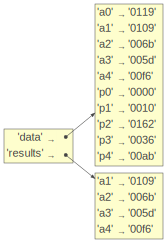

0 : p -> [ 0x0000 ] a -> 0x0119
1 : p -> [ 0x0010 ] a -> 0x0109
2 : p -> [ 0x0162 ] a -> 0x006b


In [320]:
def xorNextAddress(prevAddress, currentPointer):
    """
    Find next value address by applying XOR on previous-level address 
    and current (same-level) pointer
    Example:
    a1 = a0 XOR p1
    a2 = a1 XOR p2
    ...
    a(n) = a(n-1) XOR p(n)
    """
    defaultLength = 16
    if (not(isinstance(prevAddress, Bits))):
        prevAddress = Bits(uint=prevAddress, length=defaultLength)
    if (not(isinstance(currentPointer, Bits))):
        currentPointer = Bits(uint=currentPointer, length=defaultLength)
    # TODO check that result is not zero (0x0000...)
    nextAddress = (prevAddress ^ currentPointer)
    return nextAddress

# test data
a0 = mappedList[0]["index"]["nextAddress"]
a1 = mappedList[1]["index"]["nextAddress"]
a2 = mappedList[2]["index"]["nextAddress"]
a3 = mappedList[3]["index"]["nextAddress"]
a4 = mappedList[4]["index"]["nextAddress"]
p0 = mappedList[0]["index"]["pointer"]
p1 = mappedList[1]["index"]["pointer"]
p2 = mappedList[2]["index"]["pointer"]
p3 = mappedList[3]["index"]["pointer"]
p4 = mappedList[4]["index"]["pointer"]

xorNextAddressTest = {
    "data": {
        "a0": a0.hex,
        "a1": a1.hex,
        "a2": a2.hex,
        "a3": a3.hex,
        "a4": a4.hex,
        "p0": p0.hex,
        "p1": p1.hex,
        "p2": p2.hex,
        "p3": p3.hex,
        "p4": p4.hex,
    },
    "results": {
        "a1": xorNextAddress(a0, p1).hex,
        "a2": xorNextAddress(a1, p2).hex,
        "a3": xorNextAddress(a2, p3).hex,
        "a4": xorNextAddress(a3, p4).hex,
    }
}

display(objviz(xorNextAddressTest))

for itemIndex in range(0, 3):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", 'p -> [', itemData["index"]["pointer"], ']', 'a ->', itemData["index"]["nextAddress"])

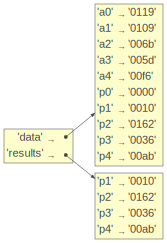

0 : p -> [ 0x0000 ] a -> 0x0119
1 : p -> [ 0x0010 ] a -> 0x0109
2 : p -> [ 0x0162 ] a -> 0x006b
3 : p -> [ 0x0036 ] a -> 0x005d
4 : p -> [ 0x00ab ] a -> 0x00f6
5 : p -> [ 0x00a3 ] a -> 0x0055


In [319]:
def xorNextPointer(prevAddress, nextAddress):
    """
    Find next XOR pointer value from 2 closest addresses
    Example:
    p1 = a0 XOR a1
    p2 = a1 XOR a2
    ...
    p(n) = a(n-1) XOR a(n)
    """
    defaultLength = 16
    if (not(isinstance(prevAddress, Bits))):
        prevAddress = Bits(uint=prevAddress, length=defaultLength)
    if (not(isinstance(nextAddress, Bits))):
        nextAddress = Bits(uint=nextAddress, length=defaultLength)
    # TODO check that result is not zero (0x0000...)
    nextPointer = (prevAddress ^ nextAddress)
    return nextPointer

# test data
a0 = mappedList[0]["index"]["nextAddress"]
a1 = mappedList[1]["index"]["nextAddress"]
a2 = mappedList[2]["index"]["nextAddress"]
a3 = mappedList[3]["index"]["nextAddress"]
a4 = mappedList[4]["index"]["nextAddress"]
p0 = mappedList[0]["index"]["pointer"]
p1 = mappedList[1]["index"]["pointer"]
p2 = mappedList[2]["index"]["pointer"]
p3 = mappedList[3]["index"]["pointer"]
p4 = mappedList[4]["index"]["pointer"]

xorNextPointerTest = {
    "data": {
        "a0": a0.hex,
        "a1": a1.hex,
        "a2": a2.hex,
        "a3": a3.hex,
        "a4": a4.hex,
        "p0": p0.hex,
        "p1": p1.hex,
        "p2": p2.hex,
        "p3": p3.hex,
        "p4": p4.hex,
    },
    "results": {
        "p1": xorNextPointer(a0, a1).hex,
        "p2": xorNextPointer(a1, a2).hex,
        "p3": xorNextPointer(a2, a3).hex,
        "p4": xorNextPointer(a3, a4).hex,
    }
}
display(objviz(xorNextPointerTest))

for itemIndex in range(0, 6):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", 'p -> [', itemData["index"]["pointer"], ']', 'a ->', itemData["index"]["nextAddress"])

In [326]:
def findNextItem(prevItem, currentItem):
    """
    Find next element in XOR linked list using 2 previous elements:
    - find next item address
    - find next item pointer
    - return next item as address + pointer
    TODO: stop search if pointer and next address = 0
    """
    nextAddress = xorNextAddress(prevItem["address"], currentItem["pointer"])
    nextPointer = xorNextPointer(prevItem["address"], currentItem["address"])
    # TODO: check that address and pointer is not empty (zero)
    return {
        "address": nextAddress,
        "pointer": nextPointer
    }

# test data
a0 = mappedList[0]["index"]["nextAddress"]
a1 = mappedList[1]["index"]["nextAddress"]
a2 = mappedList[2]["index"]["nextAddress"]
a3 = mappedList[3]["index"]["nextAddress"]
a4 = mappedList[4]["index"]["nextAddress"]
p0 = mappedList[0]["index"]["pointer"]
p1 = mappedList[1]["index"]["pointer"]
p2 = mappedList[2]["index"]["pointer"]
p3 = mappedList[3]["index"]["pointer"]
p4 = mappedList[4]["index"]["pointer"]

readNextItemTestData1 = {
    "data": {
        "prev": {
            "address": a0,
            "pointer": p0,
        },
        "current": {
            "address": a1,
            "pointer": p1,
        }
    }, 
}
readNextItemTestData2 = {
    "data": {
        "prev": {
            "address": a1,
            "pointer": p1,
        },
        "current": {
            "address": a2,
            "pointer": p2,
        }
    }, 
}
readNextItemTestData3 = {
    "data": {
        "prev": {
            "address": a2,
            "pointer": p2,
        },
        "current": {
            "address": a3,
            "pointer": p3,
        }
    }, 
}
readNextItemTestData4 = {
    "data": {
        "prev": {
            "address": a3,
            "pointer": p3,
        },
        "current": {
            "address": a4,
            "pointer": p4,
        }
    }, 
}
findNexItemTest1 = findNextItem(readNextItemTestData1['data']['prev'], readNextItemTestData1['data']['current'])
findNexItemTest2 = findNextItem(readNextItemTestData2['data']['prev'], readNextItemTestData2['data']['current'])
findNexItemTest3 = findNextItem(findNexItemTest1, findNexItemTest2)
findNexItemTest4 = findNextItem(findNexItemTest2, findNexItemTest3)
# findNexItemTest4 = findNextItem(findNexItemTest3, findNexItemTest4)
findNextItemTest = {
    "data": {
        "item1": {
            "prev": {
                "address": a0.hex,
                "pointer": p0.hex,
            },
            "current": {
                "address": a1.hex,
                "pointer": p1.hex,
            },
        },
        "item2": {
            "prev": {
                "address": a1.hex,
                "pointer": p1.hex,
            },
            "current": {
                "address": a2.hex,
                "pointer": p2.hex,
            },
        },
        "item3": {
            "prev": {
                "address": a2.hex,
                "pointer": p2.hex,
            },
            "current": {
                "address": a3.hex,
                "pointer": p3.hex,
            },
        },
        "item4": {
            "prev": {
                "address": a3.hex,
                "pointer": p3.hex,
            },
            "current": {
                "address": a4.hex,
                "pointer": p4.hex,
            },
        }
    },
    "results": {
        'item1': {
            'address': findNexItemTest1["address"].hex,
            'pointer': findNexItemTest1["pointer"].hex,
        },
        'item2': {
            'address': findNexItemTest2["address"].hex,
            'pointer': findNexItemTest2["pointer"].hex,
        },
        'item3': {
            'address': findNexItemTest3["address"].hex,
            'pointer': findNexItemTest3["pointer"].hex,
        },
        'item4': {
            'address': findNexItemTest4["address"].hex,
            'pointer': findNexItemTest4["pointer"].hex,
        }
    },
}
print(findNextItemTest)
display(objviz(findNextItemTest))

for itemIndex in range(0, 6):
    itemData = mappedList[itemIndex]
    print(itemIndex, ":", 'p -> [', itemData["index"]["pointer"], ']', 'a ->', itemData["index"]["nextAddress"])

{'data': {'item1': {'prev': {'address': '0119', 'pointer': '0000'}, 'current': {'address': '0109', 'pointer': '0010'}}, 'item2': {'prev': {'address': '0109', 'pointer': '0010'}, 'current': {'address': '006b', 'pointer': '0162'}}, 'item3': {'prev': {'address': '006b', 'pointer': '0162'}, 'current': {'address': '005d', 'pointer': '0036'}}, 'item4': {'prev': {'address': '005d', 'pointer': '0036'}, 'current': {'address': '00f6', 'pointer': '00ab'}}}, 'results': {'item1': {'address': '0109', 'pointer': '0010'}, 'item2': {'address': '006b', 'pointer': '0162'}, 'item3': {'address': '006b', 'pointer': '0162'}, 'item4': {'address': '0109', 'pointer': '0000'}}}


0 : p -> [ 0x0000 ] a -> 0x0119
1 : p -> [ 0x0010 ] a -> 0x0109
2 : p -> [ 0x0162 ] a -> 0x006b
3 : p -> [ 0x0036 ] a -> 0x005d
4 : p -> [ 0x00ab ] a -> 0x00f6
5 : p -> [ 0x00a3 ] a -> 0x0055


Bits('0x013f')

In [223]:
def updateCursor(cursor, nextItem):
    nextPosition = nextItem["address"].uint
    # print('nextPosition', nextItem["address"].uint)
    # print('nextPosition', nextItem["address"].hex)
    currentByte  = cursor["byte"]
    nextByte     = cursor["byte"] + nextPosition
    nextCursor   = parseBytePosition(nextByte)
    return nextCursor

startItem {'address': Bits('0x0119'), 'pointer': Bits('0x0000')}
prevItem {'address': Bits('0x0109'), 'pointer': Bits('0x0010')}
currentItem {'address': Bits('0x006b'), 'pointer': Bits('0x0162')}
cursor {'bit': 4208, 'byte': 526, 'blockBit': 112, 'blockByte': 14, 'nounce': 8}
itemData: 0xd0
nextItem: {'address': Bits('0x0109'), 'pointer': Bits('0x0010')}
nextPosition 265
nextPosition 0109
nextCursor: {'bit': 6328, 'byte': 791, 'blockBit': 184, 'blockByte': 23, 'nounce': 12}
itemData: 0xd0
nextItem: {'address': Bits('0x006b'), 'pointer': Bits('0x0162')}
nextPosition 107
nextPosition 006b
nextCursor: {'bit': 5064, 'byte': 633, 'blockBit': 456, 'blockByte': 57, 'nounce': 9}
itemData: 0xd0
{'address': Bits('0x006b'), 'pointer': Bits('0x0162')}
0 : p -> [ 0x0000 ] a -> 0x0119
{'bit': 4208, 'byte': 526, 'blockBit': 112, 'blockByte': 14, 'nounce': 8}
1 : p -> [ 0x0010 ] a -> 0x0109
{'bit': 6456, 'byte': 807, 'blockBit': 312, 'blockByte': 39, 'nounce': 12}
2 : p -> [ 0x0162 ] a -> 0x006b
{'bit

120

In [315]:
xorData = Bits('0x010203f405220000670809aaff06a1aa')
print(len(xorData))
# allocate bytes
testXorLocations = findByteLocations(xorData.tobytes())
byteLocations    = linkLocationList(testXorLocations)
byteLocations

128


[{'address': {'bit': 1488,
   'byte': 186,
   'blockBit': 464,
   'blockByte': 58,
   'nounce': 2},
  'prevDistance': None,
  'nextDistance': 80,
  'pointer': Bits('0x0000'),
  'prevAddress': None,
  'nextAddress': Bits('0x0050')},
 {'address': {'bit': 2128,
   'byte': 266,
   'blockBit': 80,
   'blockByte': 10,
   'nounce': 4},
  'prevDistance': 80,
  'nextDistance': 147,
  'pointer': Bits('0x00c3'),
  'prevAddress': Bits('0x0050'),
  'nextAddress': Bits('0x0093')},
 {'address': {'bit': 3304,
   'byte': 413,
   'blockBit': 232,
   'blockByte': 29,
   'nounce': 6},
  'prevDistance': 147,
  'nextDistance': 103,
  'pointer': Bits('0x00f4'),
  'prevAddress': Bits('0x0093'),
  'nextAddress': Bits('0x0067')},
 {'address': {'bit': 4128,
   'byte': 516,
   'blockBit': 32,
   'blockByte': 4,
   'nounce': 8},
  'prevDistance': 103,
  'nextDistance': 399,
  'pointer': Bits('0x01e8'),
  'prevAddress': Bits('0x0067'),
  'nextAddress': Bits('0x018f')},
 {'address': {'bit': 7320,
   'byte': 915,
   

In [316]:

# first byte to read
currentByte     = byteLocations[0]["address"]["byte"]
prevLocation    = byteLocations[0]
currentLocation = byteLocations[1]
nextLocation    = byteLocations[2]
prevItem = {
    "pointer": prevLocation["pointer"],
    "address": prevLocation["nextAddress"],
}
currentItem = {
    "pointer": currentLocation["pointer"],
    "address": currentLocation["nextAddress"],
}
nextItem = {
    "pointer": nextLocation["pointer"],
    "address": nextLocation["nextAddress"],
}
for i in range(0, len(byteLocations)+1):
    cursor   = parseBytePosition(currentByte)
    print(i, ':', 'cursor :', parseBytePosition(currentByte))
    print(i, ':', 'current byte:', currentByte, readBytePosition(currentByte))
    print(i, ':', 'prev   :', prevItem)
    print(i, ':', 'current:', currentItem)
    print(i, ':', 'next   :', nextItem)
    # update byte position
    currentByte = currentByte + prevItem["address"].uint
    # move to next element
    prevItem    = currentItem
    currentItem = nextItem
    nextItem    = findNextItem(prevItem, currentItem)

0 : cursor : {'bit': 1488, 'byte': 186, 'blockBit': 464, 'blockByte': 58, 'nounce': 2}
0 : current byte: 186 0x01
0 : prev   : {'pointer': Bits('0x0000'), 'address': Bits('0x0050')}
0 : current: {'pointer': Bits('0x00c3'), 'address': Bits('0x0093')}
0 : next   : {'pointer': Bits('0x00f4'), 'address': Bits('0x0067')}
1 : cursor : {'bit': 2128, 'byte': 266, 'blockBit': 80, 'blockByte': 10, 'nounce': 4}
1 : current byte: 266 0x02
1 : prev   : {'pointer': Bits('0x00c3'), 'address': Bits('0x0093')}
1 : current: {'pointer': Bits('0x00f4'), 'address': Bits('0x0067')}
1 : next   : {'address': Bits('0x0067'), 'pointer': Bits('0x00f4')}
2 : cursor : {'bit': 3304, 'byte': 413, 'blockBit': 232, 'blockByte': 29, 'nounce': 6}
2 : current byte: 413 0x03
2 : prev   : {'pointer': Bits('0x00f4'), 'address': Bits('0x0067')}
2 : current: {'address': Bits('0x0067'), 'pointer': Bits('0x00f4')}
2 : next   : {'address': Bits('0x0093'), 'pointer': Bits('0x0000')}
3 : cursor : {'bit': 4128, 'byte': 516, 'blockB

In [356]:
locations = findByteLocations(Bits('0x010203f405220000670809aaff06a1aa').tobytes())
linkedPositions = list()
prevPosition = 0
prevDistance = locations[0]["address"]["byte"]
prevPointer  = Bits('0x0000')
for i in range(0, len(locations)-1):
    location        = locations[i]
    currentPosition = locations[i]["address"]["byte"]
    if (i > 0):
        prevPosition = locations[i-1]["address"]["byte"]
    prevDistance    = currentPosition-prevPosition
    nextPosition    = locations[i+1]["address"]["byte"]
    nextDistance    = nextPosition-currentPosition
    currentPosBits  = Bits(uint=currentPosition, length=16)
    prevPosBits     = Bits(uint=prevPosition, length=16)
    prevDistanceBits = Bits(uint=prevPosition, length=16)
    nextDistanceBits = Bits(uint=nextDistance, length=16)
    pointer     = prevDistanceBits ^ nextDistanceBits
    linkedPositions.append({
        'prevDistance': prevDistance,
        'nextDistance': nextDistance,
        'prevDistanceBits': prevDistanceBits,
        'nextDistanceBits': nextDistanceBits,
        'pointer': pointer
    })
    #prevPointer = pointer
    # print(i, ': ', prevPosition, '[', currentPosition, '] ', nextPosition )
    print(i, ':', prevDistance, '[', currentPosition, ']', 'ptr:', pointer)
    print("")
    

0 : 186 [ 186 ] ptr: 0x0050

1 : 80 [ 266 ] ptr: 0x0029

2 : 147 [ 413 ] ptr: 0x016d

3 : 103 [ 516 ] ptr: 0x0012

4 : 399 [ 915 ] ptr: 0x01f6

5 : 1010 [ 1925 ] ptr: 0x03ac

6 : 63 [ 1988 ] ptr: 0x07c4

7 : 65 [ 2053 ] ptr: 0x0759

8 : 157 [ 2210 ] ptr: 0x0a04

9 : 513 [ 2723 ] ptr: 0x084a

10 : 232 [ 2955 ] ptr: 0x0af5

11 : 86 [ 3041 ] ptr: 0x0beb

12 : 96 [ 3137 ] ptr: 0x0b42

13 : 163 [ 3300 ] ptr: 0x0d42

14 : 259 [ 3559 ] ptr: 0x0e2e



In [358]:
for i in range(0, len(linkedPositions)):
    print(i, ':', linkedPositions[i])
    print(i, ':', linkedPositions[i]["prevDistanceBits"] ^ linkedPositions[i]["pointer"], '=', linkedPositions[i]["nextDistanceBits"])
    print(i, ':',  ^ linkedPositions[i]["pointer"], '=', linkedPositions[i]["nextDistanceBits"])
    print("")

0 : {'prevDistance': 186, 'nextDistance': 80, 'prevDistanceBits': Bits('0x0000'), 'nextDistanceBits': Bits('0x0050'), 'pointer': Bits('0x0050')}
0 : 0x0050 = 0x0050

1 : {'prevDistance': 80, 'nextDistance': 147, 'prevDistanceBits': Bits('0x00ba'), 'nextDistanceBits': Bits('0x0093'), 'pointer': Bits('0x0029')}
1 : 0x0093 = 0x0093

2 : {'prevDistance': 147, 'nextDistance': 103, 'prevDistanceBits': Bits('0x010a'), 'nextDistanceBits': Bits('0x0067'), 'pointer': Bits('0x016d')}
2 : 0x0067 = 0x0067

3 : {'prevDistance': 103, 'nextDistance': 399, 'prevDistanceBits': Bits('0x019d'), 'nextDistanceBits': Bits('0x018f'), 'pointer': Bits('0x0012')}
3 : 0x018f = 0x018f

4 : {'prevDistance': 399, 'nextDistance': 1010, 'prevDistanceBits': Bits('0x0204'), 'nextDistanceBits': Bits('0x03f2'), 'pointer': Bits('0x01f6')}
4 : 0x03f2 = 0x03f2

5 : {'prevDistance': 1010, 'nextDistance': 63, 'prevDistanceBits': Bits('0x0393'), 'nextDistanceBits': Bits('0x003f'), 'pointer': Bits('0x03ac')}
5 : 0x003f = 0x003f


In [ ]:
def frontLinkLocationList(locations):
    listItems     = list()
    firstLocation = locations[0]
    lastLocation  = locations[len(locations)-1]
    # prevLocation  = lastLocation
    for locationIndex in range(0, len(locations)-1):
        nextLocation    = locations[locationIndex+1]
        currentLocation = locations[locationIndex]
        currentAddress  = nextLocation["prevAddress"]
        # binary encoded distance to left and right elements
        currentBits  = Bits(uint=currentAddress, length=16)
        prevBits = None
        if (("prevAddress" in currentLocation) and currentLocation["prevAddress"]):
            prevBits = Bits(uint=currentLocation["prevAddress"], length=16)
        nextBits = None
        if (("nextAddress" in currentLocation) and currentLocation["nextAddress"]):
            nextBits = Bits(uint=currentLocation["nextAddress"], length=16)
        
        if (prevBits and currentBits):
            pointer = prevBits ^ currentBits
        locations[locationIndex]["pointer"] = pointer
        
        listItem = {
            "address": locationData["address"],
            "prevDistance": locationData["prevAddress"],
            "nextDistance": locationData["nextAddress"],
            "pointer": pointer, # pointerHex,
            "prevAddress": prevBits, # prevBitsHex,
            "nextAddress": nextBits, # nextBitsHex,
        }
        listItems.append(listItem)
    return listItems

In [359]:
locations

[{'success': True,
  'nounce': 2,
  'start': 464,
  'end': 472,
  'length': 8,
  'meta': {'value': Bits('0x01'),
   'valueLength': 8,
   'absoluteStart': 1488,
   'absoluteEnd': 1496,
   'offset': 1024,
   'fromNounce': 0,
   'toNounce': 1024,
   'blocksProcessed': 3,
   'allPositions': [464],
   'valuesFound': 1},
  'address': {'bit': 1488,
   'byte': 186,
   'blockBit': 464,
   'blockByte': 58,
   'nounce': 2},
  'prevAddress': None,
  'nextAddress': 80},
 {'success': True,
  'nounce': 4,
  'start': 80,
  'end': 88,
  'length': 8,
  'meta': {'value': Bits('0x02'),
   'valueLength': 8,
   'absoluteStart': 2128,
   'absoluteEnd': 2136,
   'offset': 2048,
   'fromNounce': 3,
   'toNounce': 1027,
   'blocksProcessed': 2,
   'allPositions': [80],
   'valuesFound': 1},
  'address': {'bit': 2128,
   'byte': 266,
   'blockBit': 80,
   'blockByte': 10,
   'nounce': 4},
  'prevAddress': 80,
  'nextAddress': 147},
 {'success': True,
  'nounce': 6,
  'start': 232,
  'end': 240,
  'length': 8,
  

In [360]:
Bits('0x010203f405220000670809aaff06a1aa').tobytes()

b'\x01\x02\x03\xf4\x05"\x00\x00g\x08\t\xaa\xff\x06\xa1\xaa'

In [371]:
# print(len(locations))
distances = list()
for i in range(len(locations)-1, -1, -1):
    # nextLocation = locations[i+1]
    distances.append(locations[i]["nextAddress"])
    print(i, ':', locations[i]["meta"]["value"], 'd:', locations[i]["nextAddress"])
print(distances)

15 : 0xaa d: None
14 : 0xa1 d: 714
13 : 0x06 d: 259
12 : 0xff d: 163
11 : 0xaa d: 96
10 : 0x09 d: 86
9 : 0x08 d: 232
8 : 0x67 d: 513
7 : 0x00 d: 157
6 : 0x00 d: 65
5 : 0x22 d: 63
4 : 0x05 d: 1010
3 : 0xf4 d: 399
2 : 0x03 d: 103
1 : 0x02 d: 147
0 : 0x01 d: 80
[None, 714, 259, 163, 96, 86, 232, 513, 157, 65, 63, 1010, 399, 103, 147, 80]


In [377]:
mergedValues = list()
for i in range(0, len(locations)):
    if (locations[i]["nextAddress"] == None):
        nextAddressBits = Bits('0x0000')
    else:
        nextAddressBits = Bits(uint=locations[i]["nextAddress"], length=16)
    currentValue = locations[i]["meta"]["value"]
    mergedValue = (currentValue + nextAddressBits)
    mergedValues.append(mergedValue)
mergedValues

[Bits('0x010050'),
 Bits('0x020093'),
 Bits('0x030067'),
 Bits('0xf4018f'),
 Bits('0x0503f2'),
 Bits('0x22003f'),
 Bits('0x000041'),
 Bits('0x00009d'),
 Bits('0x670201'),
 Bits('0x0800e8'),
 Bits('0x090056'),
 Bits('0xaa0060'),
 Bits('0xff00a3'),
 Bits('0x060103'),
 Bits('0xa102ca'),
 Bits('0xaa0000')]

In [382]:
findValueInHashes(Bits('0xaa'), 0, 1024, normalize=False, bytealigned=True)

{'success': True,
 'nounce': 1,
 'start': 216,
 'end': 224,
 'length': 8,
 'meta': {'value': Bits('0xaa'),
  'valueLength': 8,
  'absoluteStart': 728,
  'absoluteEnd': 736,
  'offset': 512,
  'fromNounce': 0,
  'toNounce': 1024,
  'blocksProcessed': 2,
  'allPositions': [216],
  'valuesFound': 1}}

In [384]:
for i in range(len(distances)-1, 0, -1):
    print(i, ':', distances[i])

15 : 80
14 : 147
13 : 103
12 : 399
11 : 1010
10 : 63
9 : 65
8 : 157
7 : 513
6 : 232
5 : 86
4 : 96
3 : 163
2 : 259
1 : 714


In [396]:
print(xorData, len(xorData))
nounce = 0
fourBitItems = list()
for i in range(0, 32):
    start = 4 * i
    end   = start + 4
    value = xorData[start:end]
    location = findValueInHashes(value, nounce, 1024, normalize=False, bytealigned=False)
    fourBitItems.append(value)
    print(i, ':', value, location["meta"]["absoluteStart"])
    nounce = location["nounce"]

0x010203f405220000670809aaff06a1aa 128
0 : 0x0 5
1 : 0x1 7
2 : 0x0 5
3 : 0x2 8
4 : 0x0 5
5 : 0x3 18
6 : 0xf 68
7 : 0x4 9
8 : 0x0 5
9 : 0x5 29
10 : 0x2 8
11 : 0x2 8
12 : 0x0 5
13 : 0x0 5
14 : 0x0 5
15 : 0x0 5
16 : 0x6 19
17 : 0x7 1
18 : 0x0 5
19 : 0x8 4
20 : 0x0 5
21 : 0x9 10
22 : 0xa 21
23 : 0xa 21
24 : 0xf 68
25 : 0xf 68
26 : 0x0 5
27 : 0x6 19
28 : 0xa 21
29 : 0x1 7
30 : 0xa 21
31 : 0xa 21
